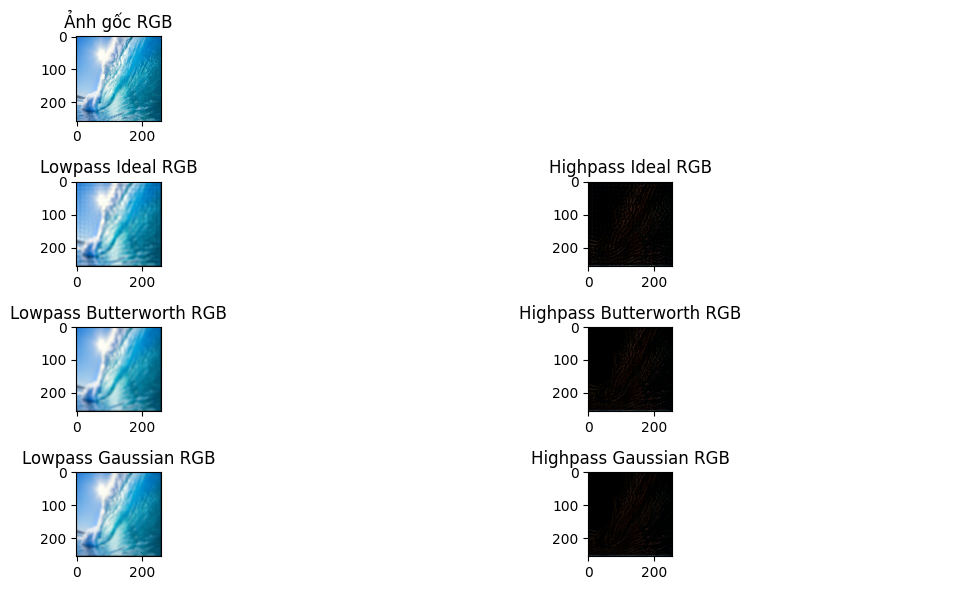

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

#BƯỚC 1: MỞ RỘNG ẢNH 
def buoc1(anh, M, N, P, Q):
    f_xy_p = np.zeros((P, Q))
    f_xy_p[:M, :N] = anh
    return f_xy_p

#BƯỚC 2: NHÂN (-1)^{x+y} 
def buoc2(f_xy_p, P, Q):
    F_xy_p = np.zeros((P, Q))
    for x in range(P):
        for y in range(Q):
            F_xy_p[x, y] = f_xy_p[x, y] * ((-1) ** (x + y))
    return F_xy_p

#FFT1D: ĐỆ QUY 
def pad_power_of_two(f):
    N = len(f)
    m = 1
    while m < N:
        m *= 2
    if m == N:
        return f
    padded = np.zeros(m, dtype=f.dtype)
    padded[:N] = f
    return padded

def FFT1D(f):
    f = pad_power_of_two(f)
    N = len(f)
    if N <= 1:
        return f
    even = FFT1D(f[0::2])
    odd = FFT1D(f[1::2])
    T = [np.exp(-2j * np.pi * k / N) * odd[k] for k in range(N // 2)]
    return [even[k] + T[k] for k in range(N // 2)] + \
           [even[k] - T[k] for k in range(N // 2)]

#FFT2D: GỌI FFT1D THEO HÀNG & CỘT 
def FFT2D(f):
    P, Q = f.shape
    P_p = 1
    while P_p < P:
        P_p *= 2
    Q_p = 1
    while Q_p < Q:
        Q_p *= 2
    f_padded = np.zeros((P_p, Q_p))
    f_padded[:P, :Q] = f

    F = np.zeros((P_p, Q_p), dtype=np.complex128)
    for i in range(P_p):
        F[i, :] = FFT1D(f_padded[i, :])
    for j in range(Q_p):
        F[:, j] = FFT1D(F[:, j])
    return F[:P, :Q]

def buoc3(F_xy_p, P, Q):
    return FFT2D(F_xy_p)

#  CÁC BỘ LỌC
#Ideals
def Lowpass_Ideals(D0, P, Q):
    H = np.zeros((P, Q))
    U0, V0 = P // 2, Q // 2
    for u in range(P):
        for v in range(Q):
            D = np.sqrt((u - U0)**2 + (v - V0)**2)
            H[u, v] = 1 if D <= D0 else 0
    return H

def Highpass_Ideals(D0, P, Q):
    return 1 - Lowpass_Ideals(D0, P, Q)

#Butterworth
def Lowpass_Butterworth(D0, n, P, Q):
    H = np.zeros((P, Q), dtype=np.float32)
    D = np.zeros((P, Q), dtype=np.float32)
    U0 =P // 2
    V0 = Q // 2
    for u in range(P):
        for v in range(Q):
            D = np.sqrt((u - U0)**2 + (v - V0)**2)
            H[u, v] = 1 / (1 + (D / D0)**(2 * n))
    return H

def Highpass_Butterworth(D0, n, P, Q):
    H = np.zeros((P, Q))
    U0 =P // 2
    V0 = Q // 2
    for u in range(P):
        for v in range(Q):
            D = np.sqrt((u - U0)**2 + (v - V0)**2)
            if D == 0:
                H[u, v] = 0  # tránh chia cho 0 ở tâm
            else:
                H[u, v] = 1 / (1 + (D0 / D)**(2 * n))
    return H

#Gaussian
def Lowpass_Gaussian(D0, P, Q):
    H = np.zeros((P, Q))
    U0 =P // 2
    V0 = Q // 2
    for u in range(P):
        for v in range(Q):
            D = np.sqrt((u - U0)**2 + (v - V0)**2)
            H[u, v] = np.exp(-(D**2) / (2 * (D0**2)))
    return H

def Highpass_Gaussian(D0, P, Q):
    return 1 - Lowpass_Gaussian(D0, P, Q)

#IFFT: NGHỊCH BIẾN ĐỔI FFT
def IFFT1D(F):
    F = pad_power_of_two(F)
    N = len(F)
    if N <= 1:
        return F
    even = IFFT1D(F[0::2])
    odd = IFFT1D(F[1::2])
    T = [np.exp(2j * np.pi * k / N) * odd[k] for k in range(N // 2)]
    return [(even[k] + T[k]) / 2 for k in range(N // 2)] + \
           [(even[k] - T[k]) / 2 for k in range(N // 2)]

def IFFT2D(F):
    P, Q = F.shape
    P_p = 1
    while P_p < P:
        P_p *= 2
    Q_p = 1
    while Q_p < Q:
        Q_p *= 2
    F_padded = np.zeros((P_p, Q_p), dtype=np.complex128)
    F_padded[:P, :Q] = F

    f = np.zeros((P_p, Q_p), dtype=np.complex128)
    for i in range(P_p):
        f[i, :] = IFFT1D(F_padded[i, :])
    for j in range(Q_p):
        f[:, j] = IFFT1D(f[:, j])
    return f[:P, :Q]

# BƯỚC 6 + 7: IFFT & CẮT ẢNH 
def buoc6_7(G_uv, P, Q, M, N):
    g_xy_p = IFFT2D(G_uv).real
    g_xy_p = buoc2(g_xy_p, P, Q)
    g_xy = g_xy_p[:M, :N]
    return g_xy

# ÁP DỤNG BỘ LỌC 
def loc_tan_so_anh(anh, loai_bo_loc, mode="lowpass", D0=50, n=2):
    M, N = anh.shape
    P, Q = 2 * M, 2 * N
    f_xy_p = buoc1(anh, M, N, P, Q)
    F_xy_p = buoc2(f_xy_p, P, Q)
    F_uv = buoc3(F_xy_p, P, Q)

    if loai_bo_loc == "ideals":
        H_uv = Lowpass_Ideals(D0, P, Q) if mode == "lowpass" else Highpass_Ideals(D0, P, Q)
    elif loai_bo_loc == "butterworth":
        H_uv = Lowpass_Butterworth(D0, n, P, Q) if mode == "lowpass" else Highpass_Butterworth(D0, n, P, Q)
    elif loai_bo_loc == "gaussian":
        H_uv = Lowpass_Gaussian(D0, P, Q) if mode == "lowpass" else Highpass_Gaussian(D0, P, Q)
    else:
        raise ValueError("Bộ lọc không hợp lệ")

    G_uv = F_uv * H_uv
    return buoc6_7(G_uv, P, Q, M, N) 

#ÁP DỤNG LỌC ẢNH 1 KÊNH
def loc_tan_so_anh_1kenh(anh, loai_bo_loc, mode="lowpass", D0=50, n=2):
    # Giữ nguyên hàm loc_tan_so_anh 
    return loc_tan_so_anh(anh, loai_bo_loc, mode, D0, n)

#SAU ĐÓ HÀM XỬ LÝ ẢNH RGB
def loc_tan_so_anh_RGB(anh_rgb, loai_bo_loc, mode="lowpass", D0=50, n=2):
    ketqua = np.zeros_like(anh_rgb, dtype=np.float32)
    # Xử lý từng kênh R, G, B riêng biệt
    for c in range(3):  
        kenh = anh_rgb[:, :, c].astype(np.float32)
        kenh_loc = loc_tan_so_anh_1kenh(kenh, loai_bo_loc, mode, D0, n)
        ketqua[:, :, c] = kenh_loc
    # Giới hạn giá trị trong [0,255]
    ketqua = np.clip(ketqua, 0, 255).astype(np.uint8)
    return ketqua

if __name__ == "__main__":
    anh_rgb = cv2.imread("C:\\Users\\van12\\Downloads\\wave.png", cv2.IMREAD_COLOR)
    anh_rgb = cv2.resize(anh_rgb, (256, 256))

    fig = plt.figure(figsize=(12, 6))
    ax = fig.subplots(4, 2)

    # Ảnh gốc RGB
    ax[0,0].imshow(cv2.cvtColor(anh_rgb, cv2.COLOR_BGR2RGB))
    ax[0,0].set_title("Ảnh gốc RGB")
    ax[0,1].axis('off')

    # Lowpass Ideal RGB
    lp_ideal = loc_tan_so_anh_RGB(anh_rgb, "ideals", "lowpass", D0=40)
    ax[1,0].imshow(cv2.cvtColor(lp_ideal, cv2.COLOR_BGR2RGB))
    ax[1,0].set_title("Lowpass Ideal RGB")

    # Highpass Ideal RGB
    hp_ideal = loc_tan_so_anh_RGB(anh_rgb, "ideals", "highpass", D0=40)
    ax[1,1].imshow(cv2.cvtColor(hp_ideal, cv2.COLOR_BGR2RGB))
    ax[1,1].set_title("Highpass Ideal RGB")

    # Lowpass Butterworth RGB
    lp_butter = loc_tan_so_anh_RGB(anh_rgb, "butterworth", "lowpass", D0=40, n=2)
    ax[2,0].imshow(cv2.cvtColor(lp_butter, cv2.COLOR_BGR2RGB))
    ax[2,0].set_title("Lowpass Butterworth RGB")

    # Highpass Butterworth RGB
    hp_butter = loc_tan_so_anh_RGB(anh_rgb, "butterworth", "highpass", D0=40, n=2)
    ax[2,1].imshow(cv2.cvtColor(hp_butter, cv2.COLOR_BGR2RGB))
    ax[2,1].set_title("Highpass Butterworth RGB")

    # Lowpass Gaussian RGB
    lp_gaussian = loc_tan_so_anh_RGB(anh_rgb, "gaussian", "lowpass", D0=40)
    ax[3,0].imshow(cv2.cvtColor(lp_gaussian, cv2.COLOR_BGR2RGB))
    ax[3,0].set_title("Lowpass Gaussian RGB")

    # Highpass Gaussian RGB
    hp_gaussian = loc_tan_so_anh_RGB(anh_rgb, "gaussian", "highpass", D0=40)
    ax[3,1].imshow(cv2.cvtColor(hp_gaussian, cv2.COLOR_BGR2RGB))
    ax[3,1].set_title("Highpass Gaussian RGB")

    plt.tight_layout()
    plt.show()
